# CalibSet Class

**Arquitectura nueva (Run es CIEGO):**
- `Run`: Trabaja solo con **canales** (1-14), NO sensor IDs
- `CalibSet`: Hace el mapping canal→sensor
  - `sensors[0]` = sensor en canal 1
  - `sensors[1]` = sensor en canal 2
  - ...
  - `sensors[11]` = sensor en canal 12
- `CalibSet.runs`: Lista de ~4 Runs válidos
- `CalibSet.sensors`: 12 objetos Sensor con offset y offset_error calculados

**Flujo de datos:**
```
Run (canales) → CalibSet (mapping) → Sensor (IDs)
  {1: offset}  →  sensors[0].offset  → Sensor(id=48176).offset
  {2: offset}  →  sensors[1].offset  → Sensor(id=48177).offset
```

**Media ponderada:**
- Cada Run tiene `offset_errors` por canal
- CalibSet usa estos errores para ponderar
- `w_i = 1/σ_i²` (menor error = mayor peso)

**Importante:** CalibSet NO sabe de raised sensors o parent_sets. Eso es Tree.

---

## 1. Setup e Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Añadir path del proyecto (src)
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Imports locales
from calibset import CalibSet
from sensor import Sensor
from run import Run
from utils.config import load_config
from utils.set_utils import create_calibration_set
from utils.run_utils import process_run_complete
from utils.filtering import filter_valid_runs

print("  CalibSet hace el mapping: sensors[channel-1] = Sensor para ese canal")

print("[OK] Imports exitosos")
print("\n[IMPORTANTE] Run es CIEGO - trabaja con canales (1-14)")

  CalibSet hace el mapping: sensors[channel-1] = Sensor para ese canal
[OK] Imports exitosos

[IMPORTANTE] Run es CIEGO - trabaja con canales (1-14)


## 2. Cargar Config y Logfile

In [2]:
# Cargar configuración
config = load_config()
print(f"Config cargado con {len(config.get('sensors', {}).get('sets', {}))} sets")

# Cargar logfile
logfile_path = project_root / "data" / "LogFile.csv"
logfile = pd.read_csv(logfile_path)
print(f"Logfile cargado: {len(logfile)} runs")

Config cargado con 60 sets
Logfile cargado: 832 runs


## 3. Crear un CalibSet vacío

In [3]:
# Crear CalibSet vacío
calib_set = CalibSet(set_number=3.0)

print(f"CalibSet creado: {calib_set}")
print(f"  - set_number: {calib_set.set_number}")
print(f"  - sensors: {len(calib_set.sensors)} instancias")
print(f"  - runs: {len(calib_set.runs)} instancias")
print(f"  - reference_sensors: {len(calib_set.reference_sensors)}")
print(f"  - mean_offsets: {len(calib_set.mean_offsets)}")
print(f"  - std_offsets: {len(calib_set.std_offsets)}")

CalibSet creado: CalibSet(set=3.0, sensors=0)
  - set_number: 3.0
  - sensors: 0 instancias
  - runs: 0 instancias
  - reference_sensors: 0
  - mean_offsets: 0
  - std_offsets: 0


## 4. Crear CalibSet completo con utils (TODO AUTOMÁTICO)

In [4]:
# UNA SOLA LLAMADA - Utils hace todo el trabajo
# NOTA: create_calibration_set retorna (calib_set, mean_offsets, std_offsets)
# pero mean_offsets y std_offsets son para debugging, no se usan directamente
# Los offsets finales están en sensor.offset y sensor.offset_error
calib_set, mean_offsets_debug, std_offsets_debug = create_calibration_set(
    set_number=3.0,
    logfile=logfile,
    config=config
)

print(f"\n{calib_set}")
print(f"\nDetalles:")
print(f"  - Set number: {calib_set.set_number}")
print(f"  - Sensors: {len(calib_set.sensors)} instancias")
print(f"  - Runs: {len(calib_set.runs)} válidos")

# Contar sensores con offset calculado (están en mean_offsets)
print(f"  - Sensores con offset: {len(calib_set.mean_offsets)}/{len(calib_set.sensors)}")

[OK] Set 3.0: 12 sensores creados
  Referencia: 48060 (canal 1)
  Procesando 4 runs válidos...
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_7: 821 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_8: 2260 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_9: 794 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_10: 680 registros, 14 canales
  [OK] 4 runs válidos con offsets
  [OK] Estadísticas calculadas: 12/12 sensores

CalibSet(set=3.0, sensors=12)

Detalles:
  - Set number: 3.0
  - Sensors: 12 instancias
  - Runs: 4 válidos
  - Sensores con offset: 12/12


## 5. Explorar los Sensors del CalibSet

In [5]:
print("Sensors en el CalibSet:")
print("=" * 50)

# Iterar sobre el Set de Sensors
for sensor in sorted(calib_set.sensors, key=lambda s: s.id):
    print(f"  {sensor}")

print(f"\nTotal: {len(calib_set.sensors)} sensores")

Sensors en el CalibSet:
  Sensor(id=48060)
  Sensor(id=48061)
  Sensor(id=48062)
  Sensor(id=48063)
  Sensor(id=48202)
  Sensor(id=48203)
  Sensor(id=48204)
  Sensor(id=48205)
  Sensor(id=48476)
  Sensor(id=48477)
  Sensor(id=48478)
  Sensor(id=48479)

Total: 12 sensores


## 6. Explorar los Runs del CalibSet

In [6]:
print("Runs en el CalibSet:")
print("=" * 50)
print("[RECORDATORIO] Run trabaja con CANALES, no sensor IDs")
print("  run.offsets = {channel: offset}")
print("  run.omitted_channels = {channel: razón}")
print()

# Iterar sobre la List de Runs
for i, run in enumerate(calib_set.runs, 1):
    print(f"[{i}] {run}")
    print(f"    Filename: {run.filename}")
    print(f"    Reference channel: {run.reference_channel}")
    print(f"    Offsets calculados: {len(run.offsets)} canales")

    print(f"    Canales omitidos: {len(run.omitted_channels)}")
    print(f"\n[NOTA] CalibSet usa sensors[channel-1] para mapear canales→IDs")

    print()
    print(f"Total: {len(calib_set.runs)} runs válidos")


Runs en el CalibSet:
[RECORDATORIO] Run trabaja con CANALES, no sensor IDs
  run.offsets = {channel: offset}
  run.omitted_channels = {channel: razón}

[1] Run('20220531_ln2_r48176_r48177_48060_48479_7', valid=True, offsets=12, omitted=0)
    Filename: 20220531_ln2_r48176_r48177_48060_48479_7
    Reference channel: 1
    Offsets calculados: 12 canales
    Canales omitidos: 0

[NOTA] CalibSet usa sensors[channel-1] para mapear canales→IDs

Total: 4 runs válidos
[2] Run('20220531_ln2_r48176_r48177_48060_48479_8', valid=True, offsets=12, omitted=0)
    Filename: 20220531_ln2_r48176_r48177_48060_48479_8
    Reference channel: 1
    Offsets calculados: 12 canales
    Canales omitidos: 0

[NOTA] CalibSet usa sensors[channel-1] para mapear canales→IDs

Total: 4 runs válidos
[3] Run('20220531_ln2_r48176_r48177_48060_48479_9', valid=True, offsets=12, omitted=0)
    Filename: 20220531_ln2_r48176_r48177_48060_48479_9
    Reference channel: 1
    Offsets calculados: 12 canales
    Canales omitidos

## 7. Ver Mean Offsets y Std Offsets

In [7]:
# Crear DataFrame con los resultados  
# NOTA: CalibSet almacena offsets en mean_offsets/std_offsets dicts
offset_data = []
for sensor in sorted(calib_set.sensors, key=lambda s: s.id):
    sensor_id = sensor.id
    channel = calib_set.sensors.index(sensor) + 1
    
    # Contar en cuántos runs aparece este canal
    rounds = sum(1 for run in calib_set.runs if channel in run.offsets)
    
    offset_data.append({
        'sensor_id': sensor_id,
        'offset': calib_set.mean_offsets.get(sensor_id),
        'offset_error': calib_set.std_offsets.get(sensor_id),
        'rounds': rounds,
        'channel': channel
    })

df_offsets = pd.DataFrame(offset_data)

print(f"Offsets de Sensores (Set {calib_set.set_number}):")
print("[NOTA] Estos offsets ya están mapeados a sensor IDs por CalibSet")
print("  CalibSet procesó run.offsets[channel] → mean_offsets[sensor_id]\n")
display(df_offsets)

print(f"\nEstadísticas:")
print(f"  Offset promedio: {df_offsets['offset'].abs().mean():.6f} K")
print(f"  Error promedio: {df_offsets['offset_error'].mean():.6f} K")

print(f"  Max offset: {df_offsets['offset'].abs().max():.6f} K")
print(f"  Sensores con offset: {df_offsets['offset'].notna().sum()}/{len(df_offsets)}")

print(f"  Max error: {df_offsets['offset_error'].max():.6f} K")

Offsets de Sensores (Set 3.0):
[NOTA] Estos offsets ya están mapeados a sensor IDs por CalibSet
  CalibSet procesó run.offsets[channel] → mean_offsets[sensor_id]



,sensor_id,offset,offset_error,rounds,channel
0,48060,0.000000,0.000000,4,1
1,48061,-0.033575,0.000141,4,2
2,48062,-0.023372,0.000160,4,3
3,48063,-0.034028,0.000176,4,4
4,48202,-0.100688,0.000172,4,5
5,48203,-0.073624,0.000183,4,6
6,48204,-0.041609,0.000179,4,7
7,48205,0.257481,0.000178,4,8
8,48476,-0.084025,0.000188,4,9
9,48477,-0.083423,0.000172,4,10



Estadísticas:
  Offset promedio: 0.070600 K
  Error promedio: 0.000158 K
  Max offset: 0.257481 K
  Sensores con offset: 12/12
  Max error: 0.000188 K


## 8. Visualizar Mean Offsets

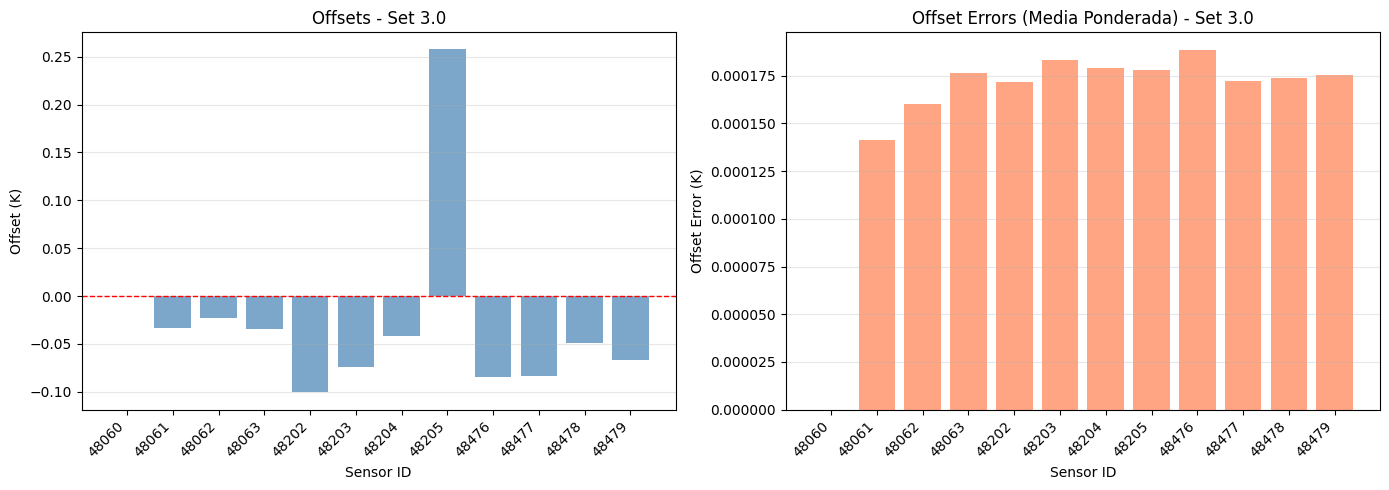

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Offsets
sensor_ids = df_offsets['sensor_id'].values
offsets = df_offsets['offset'].values
offset_errors = df_offsets['offset_error'].values

ax1.bar(range(len(sensor_ids)), offsets, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(sensor_ids)))
ax1.set_xticklabels(sensor_ids, rotation=45, ha='right')
ax1.set_xlabel('Sensor ID')
ax1.set_ylabel('Offset (K)')
ax1.set_title(f'Offsets - Set {calib_set.set_number}')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Errores
ax2.bar(range(len(sensor_ids)), offset_errors, color='coral', alpha=0.7)
ax2.set_xticks(range(len(sensor_ids)))
ax2.set_xticklabels(sensor_ids, rotation=45, ha='right')
ax2.set_xlabel('Sensor ID')
ax2.set_ylabel('Offset Error (K)')
ax2.set_title(f'Offset Errors (Media Ponderada) - Set {calib_set.set_number}')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Crear múltiples CalibSets

In [9]:
# Crear varios sets manualmente
calibsets = {}
for set_num in [3, 21, 25]:
    print(f"\nCreando CalibSet {set_num}...")
    cs, _, _ = create_calibration_set(
        set_number=float(set_num),
        logfile=logfile,
        config=config
    )
    calibsets[float(set_num)] = cs
    print(f"  ✓ {len(cs.runs)} runs, {len(cs.mean_offsets)} sensores con offset")

print(f"\n✓ Total: {len(calibsets)} CalibSets creados")


Creando CalibSet 3...
[OK] Set 3.0: 12 sensores creados
  Referencia: 48060 (canal 1)
  Procesando 4 runs válidos...
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_7: 821 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_8: 2260 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_9: 794 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_10: 680 registros, 14 canales
  [OK] 4 runs válidos con offsets
  [OK] Estadísticas calculadas: 12/12 sensores
  ✓ 4 runs, 12 sensores con offset

Creando CalibSet 21...
[OK] Set 21.0: 12 sensores creados
  Referencia: 49191 (canal 1)
  Procesando 4 runs válidos...
  [OK] Cargado 20250122_ln2_r49263_r49264_49191-49202_1: 659 registros, 14 canales
  [OK] Cargado 20250122_ln2_r49263_r49264_49191-49202_2: 702 registros, 14 canales
  [OK] Cargado 20250122_ln2_r49263_r49264_49191-49202_3: 674 registros, 14 canales
[WARNING] Referencia original canal 1 tiene 333 NaN (>299)
  [O

## 10. Exportar CalibSet a CSV

In [10]:
print("=" * 60)
print("⚠️  FUNCIÓN DE EXPORTACIÓN PENDIENTE DE IMPLEMENTACIÓN")
print("=" * 60)

print("\nPor ahora, los datos están en memoria:")
print(f"  - CalibSet.sensors: lista de {len(calibsets[3.0].sensors)} objetos Sensor")
print(f"  - Cada Sensor tiene: id (solo atributo)")
print(f"  - Offsets en: CalibSet.mean_offsets y CalibSet.std_offsets (dicts)")

print("\n📝 Puedes crear un DataFrame manualmente:")
if 3.0 in calibsets:
    cs = calibsets[3.0]
    export_data = []

    for sensor in cs.sensors:
        sensor_id = sensor.id
        channel = cs.sensors.index(sensor) + 1
        
        # Contar en cuántos runs aparece este canal
        rounds = sum(1 for run in cs.runs if channel in run.offsets)
        
        export_data.append({
            'set_number': cs.set_number,
            'sensor_id': sensor_id,
            'offset': cs.mean_offsets.get(sensor_id),
            'offset_error': cs.std_offsets.get(sensor_id),
            'rounds': rounds
        })
    
    df_export = pd.DataFrame(export_data)
    
    print(f"\nDataFrame de ejemplo (Set {cs.set_number}):")
    display(df_export)
    
    # CÓDIGO COMENTADO - Para cuando se implemente
    # csv_path = utils.export_calibset_to_csv(
    #     calib_set=calibsets[3.0],
    #     output_path="../data/results/calibset_3.csv"
    # )
    # print(f"✓ CSV exportado: {csv_path}")

⚠️  FUNCIÓN DE EXPORTACIÓN PENDIENTE DE IMPLEMENTACIÓN

Por ahora, los datos están en memoria:
  - CalibSet.sensors: lista de 12 objetos Sensor
  - Cada Sensor tiene: id (solo atributo)
  - Offsets en: CalibSet.mean_offsets y CalibSet.std_offsets (dicts)

📝 Puedes crear un DataFrame manualmente:

DataFrame de ejemplo (Set 3.0):


,set_number,sensor_id,offset,offset_error,rounds
0,3.0,48060,0.000000,0.000000,4
1,3.0,48061,-0.033575,0.000141,4
2,3.0,48062,-0.023372,0.000160,4
3,3.0,48063,-0.034028,0.000176,4
4,3.0,48202,-0.100688,0.000172,4
5,3.0,48203,-0.073624,0.000183,4
6,3.0,48204,-0.041609,0.000179,4
7,3.0,48205,0.257481,0.000178,4
8,3.0,48476,-0.084025,0.000188,4
9,3.0,48477,-0.083423,0.000172,4


## 10.1 Análisis de sensores omitidos

**¿Por qué un CalibSet puede tener menos de 12 offsets?**

Si el CalibSet tiene 12 sensores pero solo calcula 10 offsets, es porque:
- **2 canales fueron omitidos en todos los runs** (>40 NaN, canal defectuoso)
- Estos canales aparecen en `run.omitted_channels` con la razón
- CalibSet hace el mapping: si canal 3 siempre omitido → sensors[2].offset = None

**Arquitectura CIEGO:**
- Run trabaja con canales (1-14), NO sensor IDs
- Run calcula `run.offsets = {channel: offset}`
- CalibSet mapea `sensors[channel-1].offset = run.offsets[channel]`
- Si canal omitido en todos los runs → sensor.offset = None

**Búsqueda automática de referencia:**
- Si canal referencia tiene >40 NaN, Run busca automáticamente otro canal válido
- Intenta con canales 1-12 del set
- Solo falla si TODOS tienen >40 NaN (caso extremo)

In [11]:
# Analizar canales omitidos en los runs del Set 3
calib_set = calibsets[3.0]

print(f"CalibSet {calib_set.set_number}:")
print(f"  - Total sensores configurados: {len(calib_set.sensors)}")
sensors_with_offset = len(calib_set.mean_offsets)
print(f"  - Sensores con offsets calculados: {sensors_with_offset}")
print(f"  - Sensores sin offsets: {len(calib_set.sensors) - sensors_with_offset}")
print(f"  - Runs procesados: {len(calib_set.runs)}")
print()

print("[RECORDATORIO] Run trabaja con CANALES (1-14), no sensor IDs")
print("  run.omitted_channels = {channel: razón}")
print("  CalibSet mapea: sensors[channel-1] = sensor para ese canal\n")

# Ver qué canales fueron omitidos en cada run
print("Canales omitidos por run:")
print("=" * 70)
for i, run in enumerate(calib_set.runs, 1):
    if run.omitted_channels:
        print(f"\n[Run {i}] {run.filename}")
        for channel, reason in run.omitted_channels.items():
            # Obtener sensor ID del canal
            sensor_id = calib_set.sensors[channel-1].id if channel <= len(calib_set.sensors) else '?'
            print(f"  ⚠️  Canal {channel} (sensor {sensor_id}): {reason}")
    else:
        print(f"\n[Run {i}] {run.filename}: sin omisiones")

# Ver qué sensores nunca tuvieron offsets calculados
# Verificar cuáles sensor IDs NO están en mean_offsets
sensors_never_calculated = []
for sensor in calib_set.sensors:
    if sensor.id not in calib_set.mean_offsets:
        sensors_never_calculated.append(sensor)

if sensors_never_calculated:
    print(f"\n⚠️  Sensores NUNCA calculados (canal omitido en todos los runs):")
    for sensor in sensors_never_calculated:
        channel = calib_set.sensors.index(sensor) + 1
        print(f"    - Sensor {sensor.id} (canal {channel})")
else:
    print(f"\n✓ Todos los sensores tuvieron offsets calculados en al menos 1 run")

CalibSet 3.0:
  - Total sensores configurados: 12
  - Sensores con offsets calculados: 12
  - Sensores sin offsets: 0
  - Runs procesados: 4

[RECORDATORIO] Run trabaja con CANALES (1-14), no sensor IDs
  run.omitted_channels = {channel: razón}
  CalibSet mapea: sensors[channel-1] = sensor para ese canal

Canales omitidos por run:

[Run 1] 20220531_ln2_r48176_r48177_48060_48479_7: sin omisiones

[Run 2] 20220531_ln2_r48176_r48177_48060_48479_8: sin omisiones

[Run 3] 20220531_ln2_r48176_r48177_48060_48479_9: sin omisiones

[Run 4] 20220531_ln2_r48176_r48177_48060_48479_10: sin omisiones

✓ Todos los sensores tuvieron offsets calculados en al menos 1 run


## 10.1a Verificar media ponderada y errores por run

In [12]:
# Verificar que se calculan medias ponderadas correctamente
calib_set = calibsets[3.0]

print("Verificación de Media Ponderada")
print("=" * 70)
print("\nFórmulas utilizadas:")
print("  • Peso: w_i = 1 / σ_i²")
print("  • Media ponderada: μ = Σ(w_i * x_i) / Σ(w_i)")
print("  • Error propagado: σ = 1 / √(Σ(w_i))")
print()

print("[IMPORTANTE] CalibSet agregó offsets de múltiples runs:")
print("  1. Run calcula offset por CANAL: run.offsets[channel]")
print("  2. CalibSet acumula offsets del mismo canal de todos los runs")
print("  3. CalibSet calcula media ponderada por error")
print("  4. CalibSet almacena en: mean_offsets[sensor_id] y std_offsets[sensor_id]\n")

# Seleccionar un sensor para análisis detallado
test_sensor_id = None
test_sensor = None
for sensor in calib_set.sensors:
    if sensor.id in calib_set.mean_offsets and calib_set.mean_offsets[sensor.id] != 0.0:
        test_sensor_id = sensor.id
        test_sensor = sensor
        break

if test_sensor_id:
    channel = calib_set.sensors.index(test_sensor) + 1
    print(f"Análisis detallado para Sensor {test_sensor_id} (canal {channel}):")
    print("-" * 70)
    
    # Recopilar offsets y errores de los runs (por canal)
    offsets = []
    errors = []
    for i, run in enumerate(calib_set.runs, 1):
        if channel in run.offsets:
            offset = run.offsets[channel]
            error = run.offset_errors.get(channel, 0.0)
            offsets.append(offset)
            errors.append(error)
            print(f"  Run {i}: offset = {offset:.6f} K, error = {error:.6f} K")
    
    # Calcular media ponderada manualmente
    offsets = np.array(offsets)
    errors = np.array(errors)
    
    if np.all(errors == 0):
        print("\n  ⚠️  Todos los errores = 0, usando media simple")
        manual_mean = np.mean(offsets)
        manual_error = 0.0
    else:
        errors_safe = np.where(errors == 0, 1e-10, errors)
        weights = 1.0 / (errors_safe ** 2)
        manual_mean = np.sum(weights * offsets) / np.sum(weights)
        manual_error = 1.0 / np.sqrt(np.sum(weights))
    
    print(f"\n  Cálculo manual:")
    print(f"    Media ponderada: {manual_mean:.6f} K")
    print(f"    Error propagado: {manual_error:.6f} K")
    
    # CalibSet almacenado
    stored_mean = calib_set.mean_offsets[test_sensor_id]
    stored_error = calib_set.std_offsets[test_sensor_id]
    stored_rounds = sum(1 for run in calib_set.runs if channel in run.offsets)
    
    print(f"\n  CalibSet almacenado (Sensor {test_sensor_id}):")
    print(f"    mean_offsets[{test_sensor_id}] = {stored_mean:.6f} K")
    print(f"    std_offsets[{test_sensor_id}] = {stored_error:.6f} K")
    print(f"    rounds = {stored_rounds}")
    
    # Verificar coincidencia
    match_mean = np.isclose(manual_mean, stored_mean)
    match_error = np.isclose(manual_error, stored_error)
    
    print(f"\n  Verificación:")
    print(f"    ✓ Media coincide: {match_mean}")
    print(f"    ✓ Error coincide: {match_error}")
    
    if match_mean and match_error:
        print("\n✓ ¡Media ponderada calculada correctamente!")
    else:
        print("\n✗ Hay discrepancia en los cálculos")

print("\n" + "=" * 70)
print("Comparación: Media Simple vs Media Ponderada")
print("-" * 70)

# Comparar para varios sensores
ref_sensor_ids = {s.id for s in calib_set.reference_sensors}
for sensor_id in sorted(calib_set.mean_offsets.keys())[:5]:  # Solo primeros 5
    if sensor_id in ref_sensor_ids:
        continue
    
    # Encontrar el canal de este sensor (Run trabaja con canales, no IDs)
    channel = None
    for idx, s in enumerate(calib_set.sensors):
        if s.id == sensor_id:
            channel = idx + 1
            break
    if channel is None:
        continue
    
    # Recopilar datos por canal
    offsets = []
    errors = []
    for run in calib_set.runs:
        if channel in run.offsets:
            offsets.append(run.offsets[channel])
            errors.append(run.offset_errors.get(channel, 0.0))
    
    if len(offsets) == 0:
        continue
    
    offsets = np.array(offsets)
    errors = np.array(errors)
    
    # Media simple
    simple_mean = np.mean(offsets)
    
    # Media ponderada (del CalibSet)
    weighted_mean = calib_set.mean_offsets[sensor_id]
    
    # Diferencia
    diff = weighted_mean - simple_mean
    
    print(f"Sensor {sensor_id}:")
    print(f"  Simple: {simple_mean:.6f} K  |  Ponderada: {weighted_mean:.6f} K  |  Diff: {diff:.6f} K")

print("\n✓ Si hay diferencias, significa que la ponderación está funcionando")


Verificación de Media Ponderada

Fórmulas utilizadas:
  • Peso: w_i = 1 / σ_i²
  • Media ponderada: μ = Σ(w_i * x_i) / Σ(w_i)
  • Error propagado: σ = 1 / √(Σ(w_i))

[IMPORTANTE] CalibSet agregó offsets de múltiples runs:
  1. Run calcula offset por CANAL: run.offsets[channel]
  2. CalibSet acumula offsets del mismo canal de todos los runs
  3. CalibSet calcula media ponderada por error
  4. CalibSet almacena en: mean_offsets[sensor_id] y std_offsets[sensor_id]

Análisis detallado para Sensor 48061 (canal 2):
----------------------------------------------------------------------
  Run 1: offset = -0.033009 K, error = 0.000262 K
  Run 2: offset = -0.032723 K, error = 0.000353 K
  Run 3: offset = -0.034074 K, error = 0.000282 K
  Run 4: offset = -0.034167 K, error = 0.000259 K

  Cálculo manual:
    Media ponderada: -0.033575 K
    Error propagado: 0.000141 K

  CalibSet almacenado (Sensor 48061):
    mean_offsets[48061] = -0.033575 K
    std_offsets[48061] = 0.000141 K
    rounds = 4

 

## 10.1b Verificar que sensores descartados SÍ tienen offsets

In [13]:
# Obtener lista de sensores descartados del config
calib_set = calibsets[3.0]
set_config = config['sensors']['sets'][3.0]
discarded_sensors = set_config.get('discarded', [])

print(f"Sensores descartados en config para Set {calib_set.set_number}:")
print(f"  {discarded_sensors}")
print()

# Verificar si los descartados tienen offsets calculados
print("¿Los descartados tienen offsets en los runs?")
print("=" * 70)

for sensor_id in discarded_sensors:
    print(f"\nSensor {sensor_id} (DESCARTADO en config):")
    
    # Ver si tiene offset en el CalibSet
    if sensor_id in calib_set.mean_offsets:
        mean = calib_set.mean_offsets[sensor_id]
        std = calib_set.std_offsets[sensor_id]
        print(f"  ✓ CalibSet: mean_offset={mean:.6f} K, std={std:.6f} K")
    else:
        print(f"  ✗ CalibSet: NO tiene offset calculado")
    
    # Encontrar el canal de este sensor (Run trabaja con canales, no IDs)
    sensor_channel = None
    for idx, s in enumerate(calib_set.sensors):
        if s.id == sensor_id:
            sensor_channel = idx + 1
            break
    
    # Ver en cuántos runs tiene offset
    runs_with_offset = 0
    for run in calib_set.runs:
        if sensor_channel is not None and sensor_channel in run.offsets:
            runs_with_offset += 1
    
    print(f"  ✓ Presente en {runs_with_offset}/{len(calib_set.runs)} runs")
    
    # Ver si fue omitido en algún run (Run trabaja con canales, no IDs)
    for i, run in enumerate(calib_set.runs, 1):
        if sensor_channel is not None and sensor_channel in run.omitted_channels:
            print(f"    [Run {i}] ⚠️  Omitido (canal {sensor_channel}): {run.omitted_channels[sensor_channel]}")

print("\n" + "=" * 70)
print("✓ Run calcula offsets para TODOS los sensores (incluso descartados)")
print("✓ Tree será quien los excluya en la propagación final")


Sensores descartados en config para Set 3.0:
  [48205, 48478]

¿Los descartados tienen offsets en los runs?

Sensor 48205 (DESCARTADO en config):
  ✓ CalibSet: mean_offset=0.257481 K, std=0.000178 K
  ✓ Presente en 4/4 runs

Sensor 48478 (DESCARTADO en config):
  ✓ CalibSet: mean_offset=-0.049019 K, std=0.000174 K
  ✓ Presente en 4/4 runs

✓ Run calcula offsets para TODOS los sensores (incluso descartados)
✓ Tree será quien los excluya en la propagación final


## 10.2 Comparar Set 21 (con menos runs)

In [14]:
# Set 21 mencionaste que solo tiene 2 runs
if 21.0 in calibsets:
    calib_set_21 = calibsets[21.0]
    
    print(f"CalibSet {calib_set_21.set_number}:")
    print(f"  - Total sensores: {len(calib_set_21.sensors)}")
    print(f"  - Runs válidos: {len(calib_set_21.runs)}")
    print(f"  - Sensores con offsets: {len(calib_set_21.mean_offsets)}")
    ref_ids_21 = [s.id for s in calib_set_21.reference_sensors]
    print(f"  - Referencia: {ref_ids_21}")
    print()
    
    # Detalle de cada run
    print("Detalle de runs:")
    for i, run in enumerate(calib_set_21.runs, 1):
        print(f"\n[Run {i}] {run.filename}")
        print(f"  - Offsets calculados: {len(run.offsets)}")
        print(f"  - Canales omitidos: {len(run.omitted_channels)}")
        if run.omitted_channels:
            for channel, reason in run.omitted_channels.items():
                print(f"    ⚠️  Canal {channel}: {reason}")
    
    # Comparación de estadísticas
    print(f"\nEstadísticas (con {len(calib_set_21.runs)} runs):")
    print(f"  - Std promedio: {np.mean(list(calib_set_21.std_offsets.values())):.6f} K")
    print(f"  - Std máximo: {np.max(list(calib_set_21.std_offsets.values())):.6f} K")
    print(f"\n⚠️  Con solo {len(calib_set_21.runs)} runs, la std puede ser menos confiable")
else:
    print("Set 21 no está en los CalibSets creados, creándolo...")
    calib_set_21, _, _ = create_calibration_set(
        set_number=21.0,
        logfile=logfile,
        config=config
    )
    print(f"\n{calib_set_21}")


CalibSet 21.0:
  - Total sensores: 12
  - Runs válidos: 4
  - Sensores con offsets: 12
  - Referencia: [49191]

Detalle de runs:

[Run 1] 20250122_ln2_r49263_r49264_49191-49202_1
  - Offsets calculados: 12
  - Canales omitidos: 0

[Run 2] 20250122_ln2_r49263_r49264_49191-49202_2
  - Offsets calculados: 12
  - Canales omitidos: 0

[Run 3] 20250122_ln2_r49263_r49264_49191-49202_3
  - Offsets calculados: 11
  - Canales omitidos: 1
    ⚠️  Canal 1: defectuoso (333 NaN > 299)

[Run 4] 20250122_ln2_r49263_r49264_49191-49202_4
  - Offsets calculados: 12
  - Canales omitidos: 0

Estadísticas (con 4 runs):
  - Std promedio: 0.000189 K
  - Std máximo: 0.000276 K

⚠️  Con solo 4 runs, la std puede ser menos confiable


## 11. Comparar offsets entre múltiples runs

Ver cómo varían los offsets de cada sensor entre los diferentes runs del CalibSet.

In [15]:
# Comparar offsets de un CalibSet entre sus runs
calib_set = calibsets[3.0]

# Recopilar offsets de todos los runs
run_offsets = {}
for i, run in enumerate(calib_set.runs, 1):
    run_offsets[f"Run {i}"] = run.offsets

# Crear DataFrame
df_comparison = pd.DataFrame(run_offsets)

print(f"Comparación de offsets entre runs (Set {calib_set.set_number}):")
print("=" * 70)
display(df_comparison)

# Agregar columnas de estadísticas
df_comparison['mean'] = df_comparison.mean(axis=1)
df_comparison['std'] = df_comparison.std(axis=1)

print("\nEstadísticas por sensor:")
display(df_comparison[['mean', 'std']])

print(f"\nVariabilidad promedio entre runs: {df_comparison['std'].mean():.6f} K")

Comparación de offsets entre runs (Set 3.0):


,Run 1,Run 2,Run 3,Run 4
1,0.000000,0.000000,0.000000,0.000000
2,-0.033009,-0.032723,-0.034074,-0.034167
3,-0.023258,-0.022563,-0.023922,-0.023326
4,-0.034180,-0.033807,-0.034374,-0.033677
5,-0.099238,-0.099289,-0.102079,-0.101525
6,-0.072754,-0.073248,-0.073882,-0.074136
7,-0.040070,-0.040716,-0.042404,-0.042516
8,0.260833,0.259857,0.256067,0.255348
9,-0.082102,-0.083513,-0.084607,-0.085335
10,-0.082248,-0.082443,-0.084415,-0.084390



Estadísticas por sensor:


,mean,std
1,0.000000,0.000000
2,-0.033493,0.000636
3,-0.023267,0.000482
4,-0.034010,0.000280
5,-0.100533,0.001285
6,-0.073505,0.000541
7,-0.041427,0.001059
8,0.258026,0.002358
9,-0.083889,0.001219
10,-0.083374,0.001031



Variabilidad promedio entre runs: 0.001052 K


## 12. Visualizar variabilidad entre runs

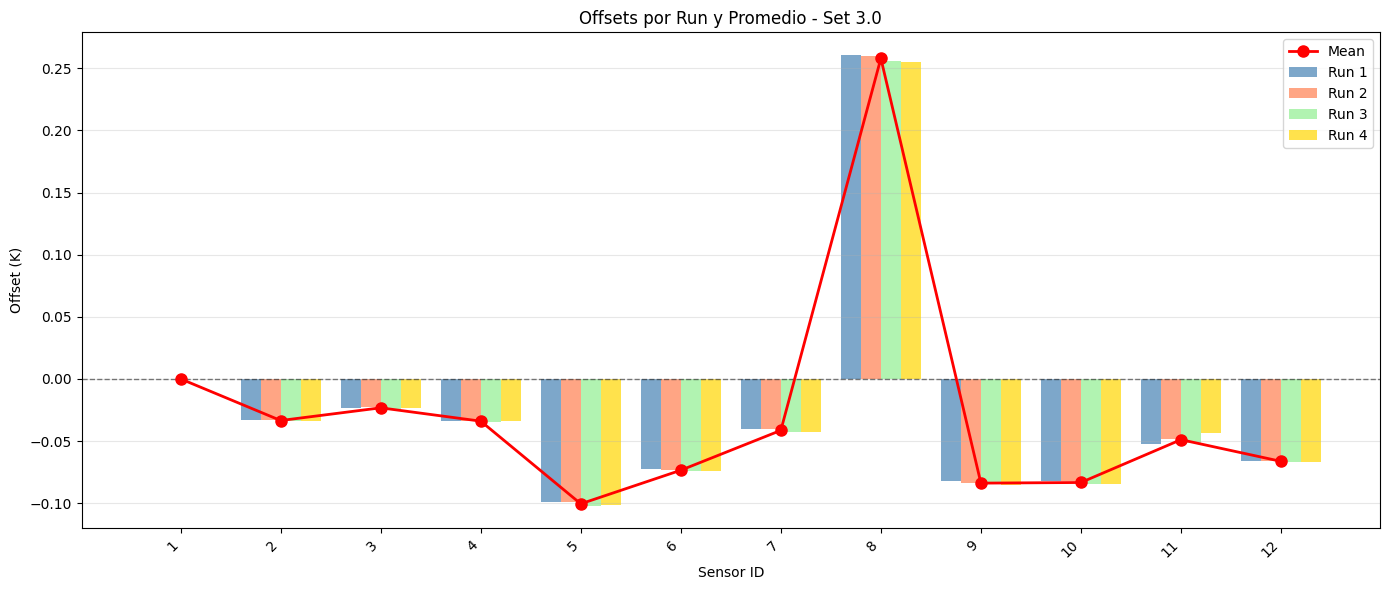

In [16]:
# Visualizar offsets de cada run + promedio
fig, ax = plt.subplots(figsize=(14, 6))

sensor_ids = df_comparison.index.values
x_pos = np.arange(len(sensor_ids))
width = 0.2

# Plot cada run
colors = ['steelblue', 'coral', 'lightgreen', 'gold']
for i, run_name in enumerate([col for col in df_comparison.columns if col.startswith('Run')]):
    offsets = df_comparison[run_name].values
    ax.bar(x_pos + i*width, offsets, width, label=run_name, alpha=0.7, color=colors[i % len(colors)])

# Plot promedio
mean_offsets = df_comparison['mean'].values
ax.plot(x_pos + 1.5*width, mean_offsets, 'ro-', linewidth=2, markersize=8, label='Mean', zorder=10)

ax.set_xlabel('Sensor ID')
ax.set_ylabel('Offset (K)')
ax.set_title(f'Offsets por Run y Promedio - Set {calib_set.set_number}')
ax.set_xticks(x_pos + 1.5*width)
ax.set_xticklabels(sensor_ids, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(loc='best')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Comparar múltiples CalibSets

Ver estadísticas comparativas entre diferentes sets.

In [17]:
# Crear resumen comparativo de CalibSets
summary_data = []
for set_num, calib_set in calibsets.items():
    summary_data.append({
        'Set': set_num,
        'N_Sensors': len(calib_set.sensors),
        'N_Runs': len(calib_set.runs),
        'N_Offsets': len(calib_set.mean_offsets),
        'Reference': str([s.id for s in calib_set.reference_sensors]),
        'Mean_Offset_Abs': np.mean(np.abs(list(calib_set.mean_offsets.values()))),
        'Mean_Std': np.mean(list(calib_set.std_offsets.values())),
        'Max_Offset_Abs': np.max(np.abs(list(calib_set.mean_offsets.values()))),
        'Max_Std': np.max(list(calib_set.std_offsets.values()))
    })

df_summary = pd.DataFrame(summary_data)

print("Resumen comparativo de CalibSets:")
print("=" * 70)
display(df_summary)

print("\nEstadísticas globales:")
print(f"  Offset promedio total: {df_summary['Mean_Offset_Abs'].mean():.6f} K")
print(f"  Std promedio total: {df_summary['Mean_Std'].mean():.6f} K")


Resumen comparativo de CalibSets:


,Set,N_Sensors,N_Runs,N_Offsets,Reference,Mean_Offset_Abs,Mean_Std,Max_Offset_Abs,Max_Std
0,3.0,12,4,12,[48060],0.070600,0.000158,0.257481,0.000188
1,21.0,12,4,12,[49191],0.022798,0.000189,0.047624,0.000276
2,25.0,12,4,12,[49250],0.018414,0.000164,0.036858,0.000208



Estadísticas globales:
  Offset promedio total: 0.037271 K
  Std promedio total: 0.000170 K


## 14. Visualizar comparación de CalibSets

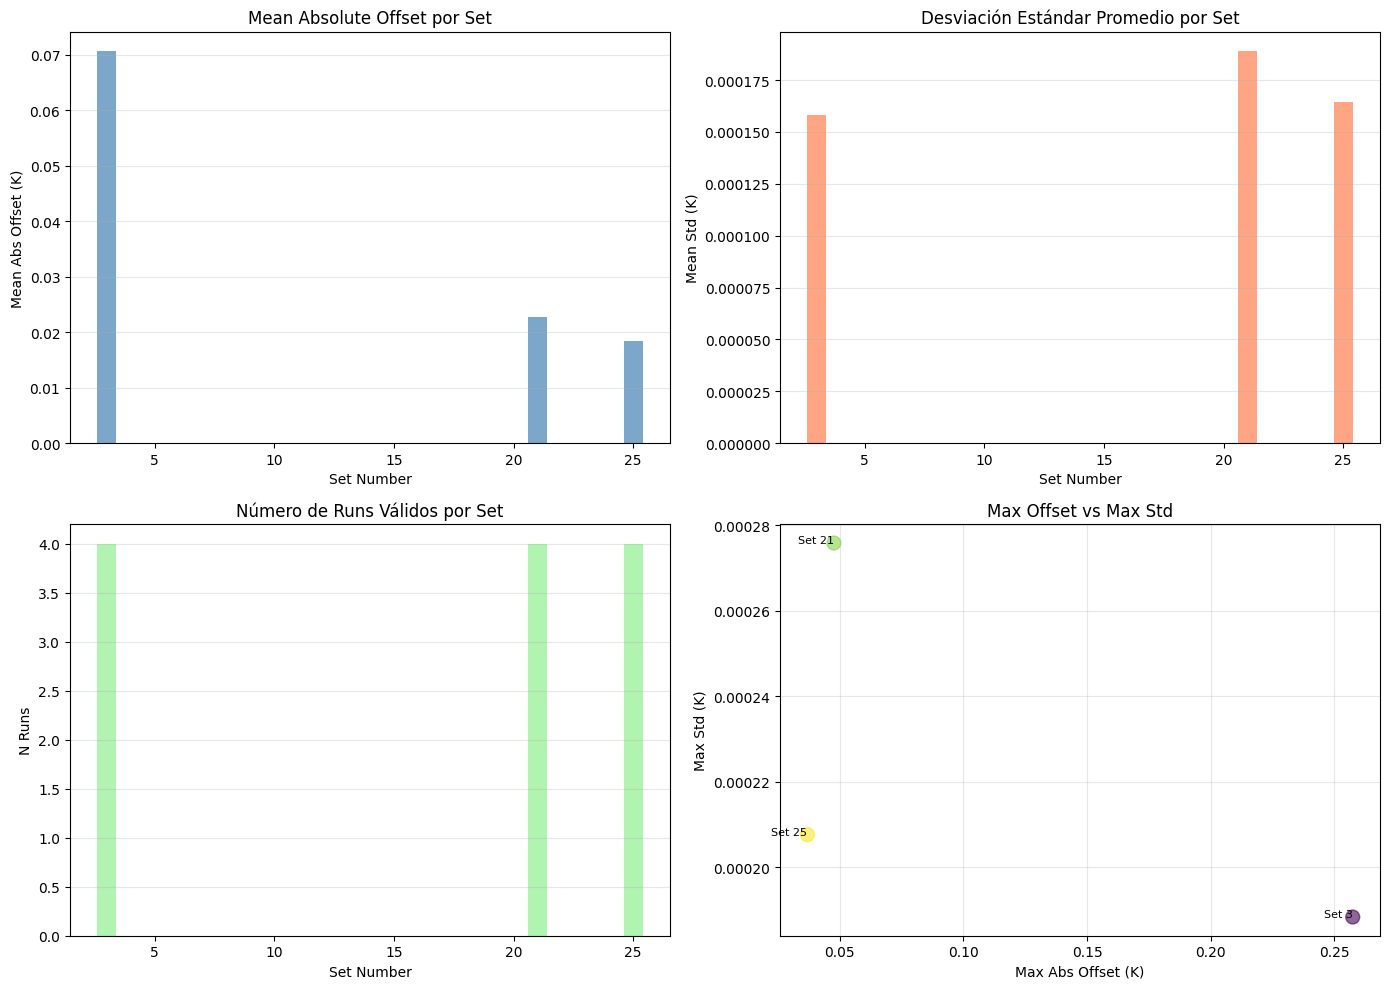

In [18]:
# Gráficos comparativos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean Offset por set
ax1 = axes[0, 0]
ax1.bar(df_summary['Set'], df_summary['Mean_Offset_Abs'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Set Number')
ax1.set_ylabel('Mean Abs Offset (K)')
ax1.set_title('Mean Absolute Offset por Set')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Std promedio por set
ax2 = axes[0, 1]
ax2.bar(df_summary['Set'], df_summary['Mean_Std'], color='coral', alpha=0.7)
ax2.set_xlabel('Set Number')
ax2.set_ylabel('Mean Std (K)')
ax2.set_title('Desviación Estándar Promedio por Set')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Número de runs por set
ax3 = axes[1, 0]
ax3.bar(df_summary['Set'], df_summary['N_Runs'], color='lightgreen', alpha=0.7)
ax3.set_xlabel('Set Number')
ax3.set_ylabel('N Runs')
ax3.set_title('Número de Runs Válidos por Set')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Max offset vs Max std
ax4 = axes[1, 1]
ax4.scatter(df_summary['Max_Offset_Abs'], df_summary['Max_Std'], 
            s=100, alpha=0.6, c=df_summary['Set'], cmap='viridis')
for idx, row in df_summary.iterrows():
    ax4.annotate(f"Set {int(row['Set'])}", 
                (row['Max_Offset_Abs'], row['Max_Std']),
                fontsize=8, ha='right')
ax4.set_xlabel('Max Abs Offset (K)')
ax4.set_ylabel('Max Std (K)')
ax4.set_title('Max Offset vs Max Std')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Resumen de la arquitectura

**Run (CIEGO a sensor IDs):**
```python
class Run:
    filename: str
    timestamps: DatetimeIndex
    temperatures: DataFrame           # Columnas = canales (1-14)
    reference_channel: int            # Canal de referencia (1-14)
    offsets: dict[int, float]         # {channel: offset}
    offset_errors: dict[int, float]   # {channel: error}
    omitted_channels: dict[int, str]  # {channel: razón}
    is_valid: bool
```

**CalibSet (hace mapping canal→sensor):**
```python
class CalibSet:
    set_number: float
    sensors: list[Sensor]             # 12 objetos Sensor (orden = canales)
                                      # sensors[0] = sensor canal 1
                                      # sensors[1] = sensor canal 2, etc.
    runs: list[Run]                   # ~4 Runs válidos
```

**Sensor (resultado final con offset calculado):**
```python
class Sensor:
    id: int                           # ID del sensor (ej: 48176)
    offset: float | None              # Media ponderada de runs
    offset_error: float | None        # Error propagado
    rounds: int                       # Número de runs usados
```

**Flujo de datos:**
```
1. Run calcula offsets por CANAL:
   run.offsets = {1: 0.0, 2: -0.033, 3: -0.023, ...}
   run.offset_errors = {1: 0.0, 2: 0.002, 3: 0.003, ...}

2. CalibSet procesa múltiples runs del mismo set:
   - Acumula offsets del mismo canal de todos los runs
   - Calcula media ponderada por error
   - Mapea resultado a sensores

3. CalibSet asigna a Sensor:
   sensors[0].offset = media_ponderada(run1.offsets[1], run2.offsets[1], ...)
   sensors[0].offset_error = error_propagado
   sensors[0].rounds = número_de_runs_usados
   sensors[0].id = 48176  # Del config
```

**Media ponderada:**
- Cada Run tiene `offset_errors` por canal
- CalibSet usa estos errores para ponderar:
  - `w_i = 1/σ_i²` (menor error = mayor peso)
  - `μ = Σ(w_i * x_i) / Σ(w_i)`
  - `σ_propagado = 1/√(Σ(w_i))`

**Ejemplo concreto:**
```python
# Set 3 tiene sensors = [Sensor(48176), Sensor(48177), ...]
# Run 1: offsets[1] = 0.0, offset_errors[1] = 0.0
# Run 2: offsets[1] = 0.0, offset_errors[1] = 0.0
# → sensors[0] = Sensor(id=48176, offset=0.0, offset_error=0.0, rounds=2)
```

**Sensores omitidos:**
- Si canal omitido en TODOS los runs → sensor.offset = None
- Razón en `run.omitted_channels[channel]`
- Causas: >40 NaN, canal defectuoso, etc.
- CalibSet simplemente no tiene datos para ese canal

**Referencia automática:**
- Si canal referencia defectuoso → Run busca otro canal válido
- `run.reference_channel` indica cuál se usó realmente

**Integración con Tree:**
- CalibSet NO sabe de raised sensors o parent_sets
- Tree usará `sensor.offset` y `sensor.offset_error` para propagación
- Tree decidirá qué sensores son "raised" comparando con parents

**Siguiente paso:** Tree class - estructura jerárquica, propagación, raised sensors